# **NLP-based Tweet Classification for improved Disaster Response**

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Import libraries for text processing and visualization
import demoji
from wordcloud import WordCloud, ImageColorGenerator
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict, Counter

# Load and set English stopwords
stop = set(stopwords.words('english'))

# Import libraries for text pre-processing
import re
from nltk.tokenize import word_tokenize
import gensim
import string

# Import Keras libraries for deep learning model creation
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading Data and Pre-processing

In [ ]:
# Read the dataset from a CSV file
#df = pd.read_csv("/content/drive/MyDrive/machine_learning/spring_2023/group project/Disaster_tweets.csv")
df = pd.read_csv("/content/drive/MyDrive/Disaster_tweets.csv")

# Drop unnecessary columns (id, keyword, and location) from the dataset
df.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

# Print the shape of the dataset (number of rows and columns)
print(df.shape)

# Display the first 5 rows of the dataset
df.head()


(7613, 2)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Text(0.5, 0, 'Disastrous')

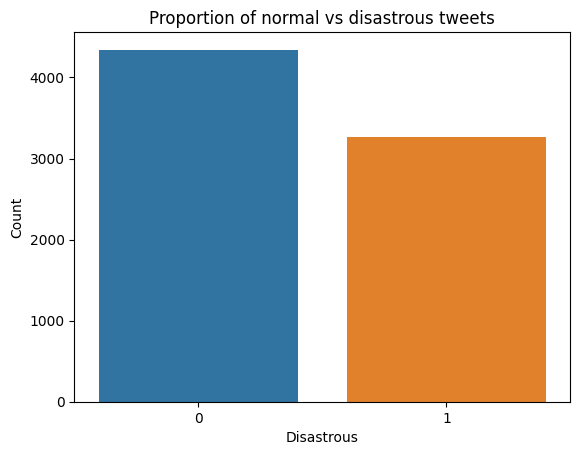

In [ ]:
# Get the value counts of the 'target' column in the dataset
vc = df['target'].value_counts()

# Create a bar plot using seaborn to visualize the counts of normal vs disastrous tweets
sns.barplot(x=vc.index, y=vc.values)

# Set the title for the bar plot
plt.title("Proportion of normal vs disastrous tweets")

# Set the y-axis label
plt.ylabel('Count')

# Set the x-axis label
plt.xlabel("Disastrous")


In [ ]:
# finding the number of characters in a tweet
df['len'] = df['text'].str.len()
df.head()

,text,target,len
0,Our Deeds are the Reason of this #earthquake M...,1,69
1,Forest fire near La Ronge Sask. Canada,1,38
2,All residents asked to 'shelter in place' are ...,1,133
3,"13,000 people receive #wildfires evacuation or...",1,65
4,Just got sent this photo from Ruby #Alaska as ...,1,88


In [ ]:
# finding number of words in a tweet
df['words'] = df['text'].apply(lambda x : len(x.split(" ")))
df.head()

,text,target,len,words
0,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,Forest fire near La Ronge Sask. Canada,1,38,7
2,All residents asked to 'shelter in place' are ...,1,133,22
3,"13,000 people receive #wildfires evacuation or...",1,65,9
4,Just got sent this photo from Ruby #Alaska as ...,1,88,17


Text(0.5, 1.0, 'Frequency distribution of characters based on disaster')

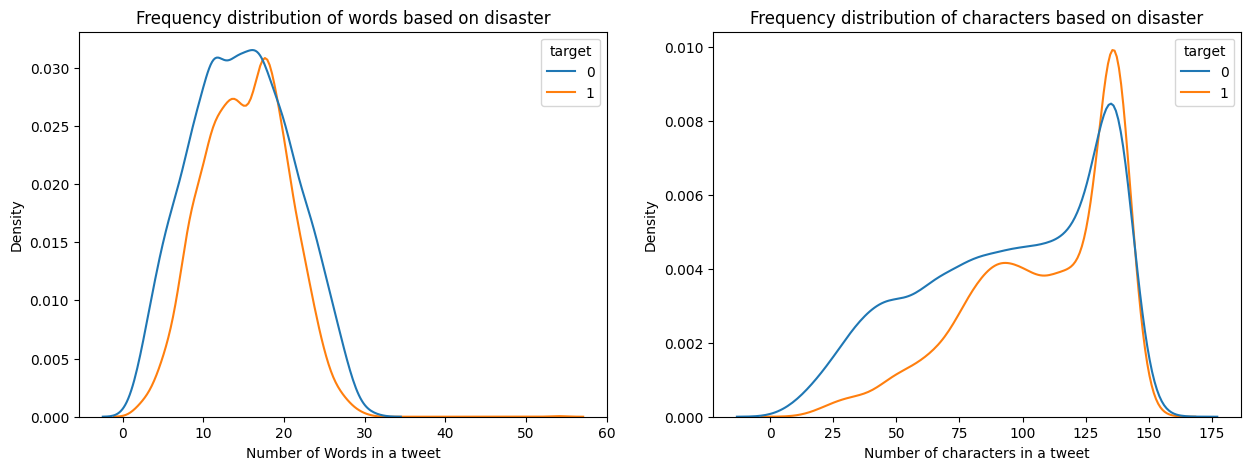

In [ ]:
# Create a 1x2 subplot grid for visualizing the frequency distribution of words and characters in tweets
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the frequency distribution of words in a tweet based on the 'target' column using seaborn's kdeplot
sns.kdeplot(ax=axes[0], x="words",  hue='target', data=df)
axes[0].set_xlabel("Number of Words in a tweet")
axes[0].set_title("Frequency distribution of words based on disaster")

# Plot the frequency distribution of characters in a tweet based on the 'target' column using seaborn's kdeplot
sns.kdeplot(ax=axes[1], data=df, x='len', hue='target')
axes[1].set_xlabel("Number of characters in a tweet")
axes[1].set_title("Frequency distribution of characters based on disaster")


In [ ]:
# Define a function to create a corpus (collection of words) for a given target value
def create_corpus(target):
    corpus = []  # Initialize an empty corpus
    
    # Iterate through the 'text' column of the dataset where the 'target' value matches the given target
    for x in df[df['target'] == target]['text'].str.split():
        # For each word in the split text, append it to the corpus
        for i in x:
            corpus.append(i)
    
    return corpus  # Return the created corpus


In [ ]:
df.head()

,text,target,len,words
0,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,Forest fire near La Ronge Sask. Canada,1,38,7
2,All residents asked to 'shelter in place' are ...,1,133,22
3,"13,000 people receive #wildfires evacuation or...",1,65,9
4,Just got sent this photo from Ruby #Alaska as ...,1,88,17


In [ ]:
# Removing usernames
def removing_usernames(text):
    text= re.sub('@[A-Za-z0-9_]+','',text)
    return text

# Removing URLs
def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Removing punctuations
def removing_punctuation(text):
    Punctuation=string.punctuation
    return text.translate(str.maketrans('','',Punctuation))

# Removing stopwords
def removing_stopwords(text):
    Stopwords=set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in Stopwords])

# Removing emoji's
def removing_emoji(text):
    text=demoji.replace(text)
    return text

# Removing numbers
def removing_numbers(text):
    text=re.sub('\d{1,10}','',text)
    return text


In [ ]:
# Apply the defined preprocessing functions to the 'text' column of the dataset and create a new column 'preprocess'

df['preprocess']=df['text'].apply(lambda text: removing_usernames(text))
df['preprocess']=df['preprocess'].apply(lambda text: removing_urls(text))
df['preprocess']=df['preprocess'].apply(lambda text: removing_punctuation(text))
df['preprocess']=df['preprocess'].apply(lambda text: removing_stopwords(text))
df['preprocess']=df['preprocess'].apply(lambda text: removing_emoji(text))
df['preprocess']=df['preprocess'].apply(lambda text: removing_numbers(text))



df.head()

,text,target,len,words,preprocess
0,Our Deeds are the Reason of this #earthquake M...,1,69,13,Our Deeds Reason earthquake May ALLAH Forgive us
1,Forest fire near La Ronge Sask. Canada,1,38,7,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,133,22,All residents asked shelter place notified off...
3,"13,000 people receive #wildfires evacuation or...",1,65,9,people receive wildfires evacuation orders Ca...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,17,Just got sent photo Ruby Alaska smoke wildfire...


In [ ]:
# creating new dataframes to plot word clouds
df_1 = df[df['target']==1]
df_0 = df[df['target']==0]
df_1.head()

,text,target,len,words,preprocess
0,Our Deeds are the Reason of this #earthquake M...,1,69,13,Our Deeds Reason earthquake May ALLAH Forgive us
1,Forest fire near La Ronge Sask. Canada,1,38,7,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,133,22,All residents asked shelter place notified off...
3,"13,000 people receive #wildfires evacuation or...",1,65,9,people receive wildfires evacuation orders Ca...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,17,Just got sent photo Ruby Alaska smoke wildfire...


In [ ]:
# Define a function to generate n-grams from the input text
from collections import defaultdict, Counter

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stop]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 20

# Create dictionaries for unigrams, bigrams, and trigrams in disaster and non-disaster tweets
# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

# Count disaster unigrams
for tweet in df_1['preprocess']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

# Count non-disaster unigrams
for tweet in df_0['preprocess']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

# Convert dictionaries to DataFrames and sort them
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

# Count disaster bigrams
for tweet in df_1['preprocess']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1

# Count non-disaster bigrams
for tweet in df_0['preprocess']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1

# Convert dictionaries to DataFrames and sort them
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

# Count disaster trigrams
for tweet in df_1['preprocess']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1

# Count non-disaster trigrams
for tweet in df_0['preprocess']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1

# Convert dictionaries to DataFrames and sort them
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])


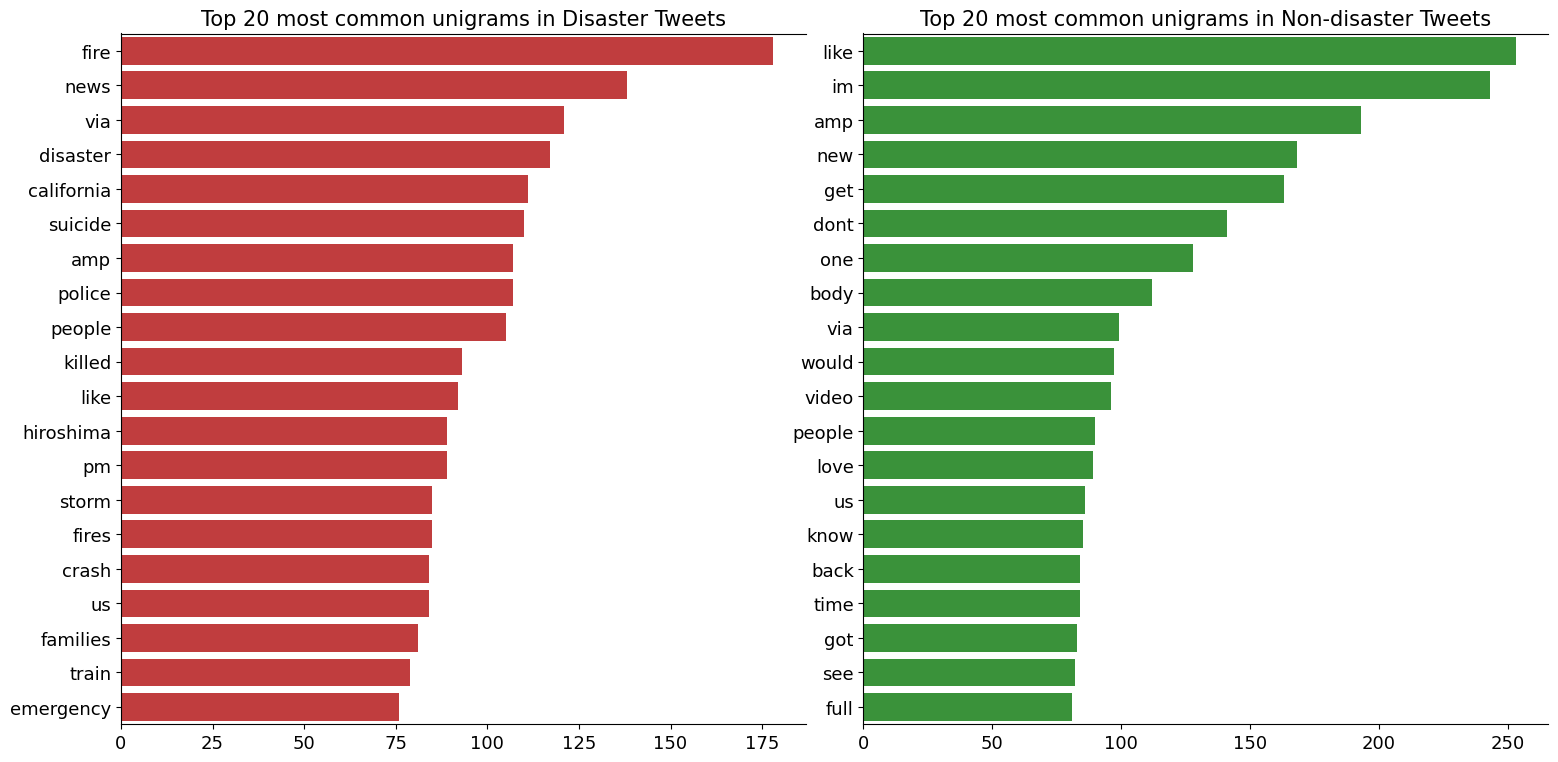

In [ ]:
# Create a bar plot to visualize the top N most common unigrams in both disaster and non-disaster tweets

# Set up the figure and axes for the subplots
fig, axes = plt.subplots(ncols=2, figsize=(15, 7.5))
plt.tight_layout()

# Plot the top N disaster unigrams on the left subplot (axes[0])
sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='#D62728')

# Plot the top N non-disaster unigrams on the right subplot (axes[1])
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='#2CA02C')

# Customize the appearance of the subplots
for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

# Set titles for each subplot
axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

# Display the plots
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


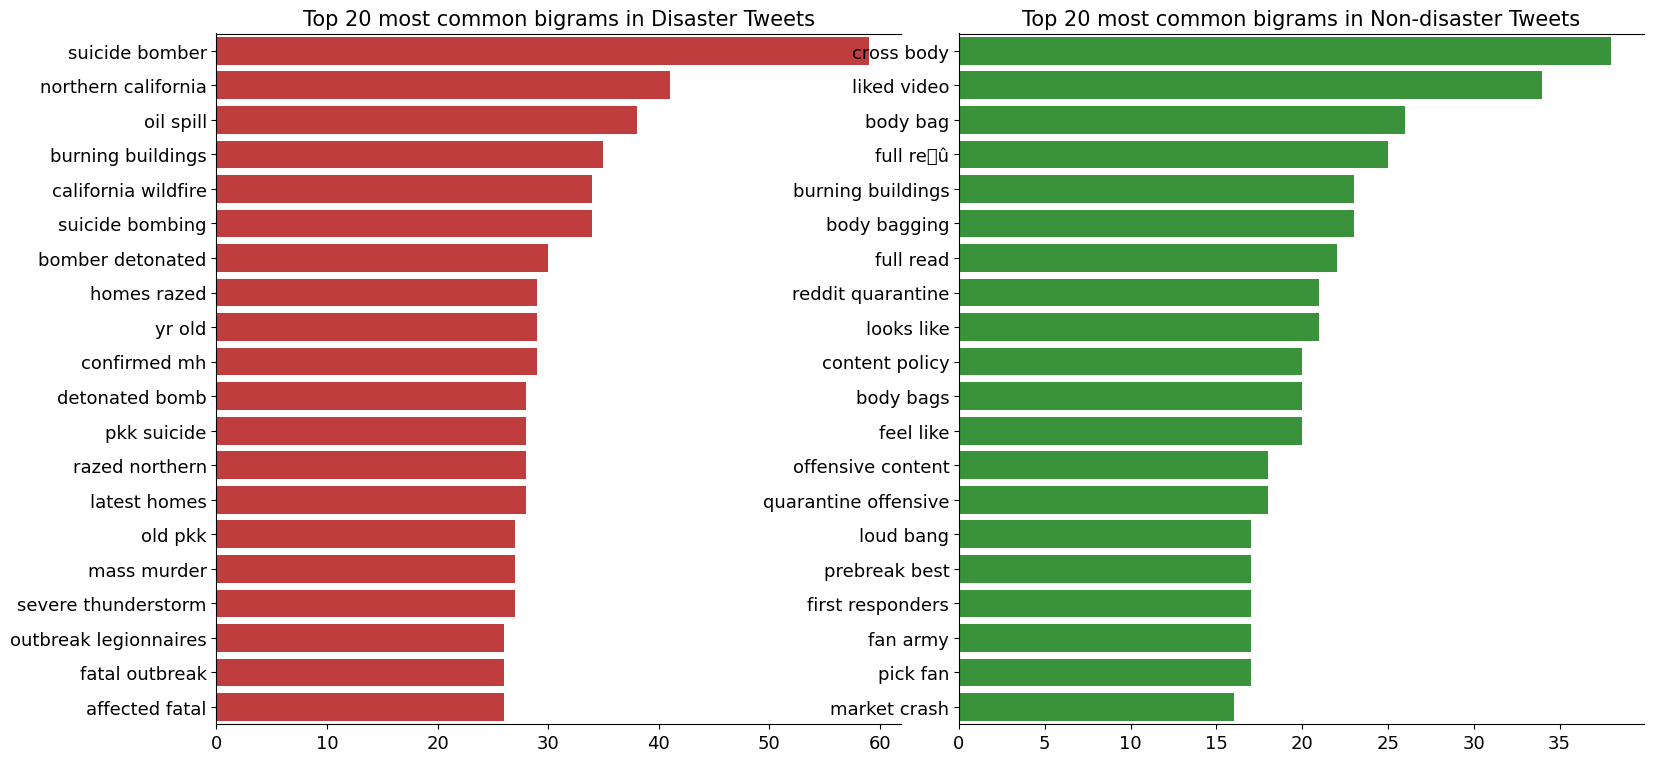

In [ ]:
# Create a bar plot to visualize the top N most common bigrams in both disaster and non-disaster tweets

# Set up the figure and axes for the subplots
fig, axes = plt.subplots(ncols=2, figsize=(15, 7.5))
plt.tight_layout()

# Plot the top N disaster bigrams on the left subplot (axes[0])
sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='#D62728')

# Plot the top N non-disaster bigrams on the right subplot (axes[1])
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='#2CA02C')

# Customize the appearance of the subplots
for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

# Set titles for each subplot
axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

# Display the plots
plt.show()


Text(0.5, 1.0, 'Wordcloud of Disastrous tweet')

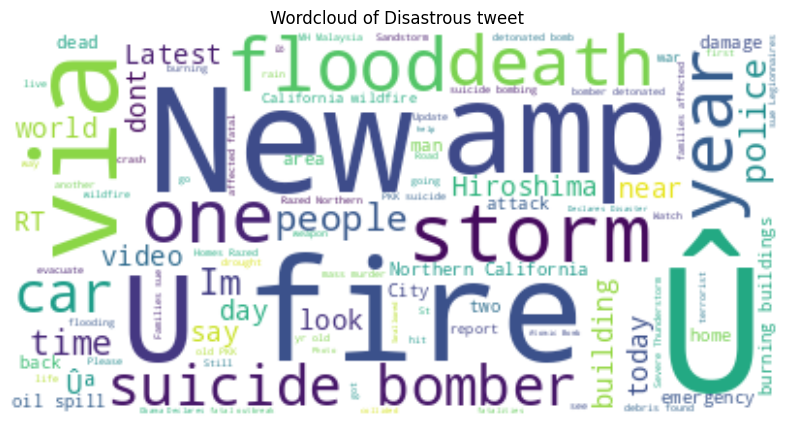

In [ ]:
# Concatenate all preprocessed text in the dataset for target value 1 (disastrous) into a single string
k_1 = (' '.join(df_1['preprocess']))

# Generate a word cloud for the disastrous tweets using the concatenated string
wordcloud = WordCloud(background_color="white", max_words=1000,
                      max_font_size=90,
                      contour_width=0.01, contour_color='green').generate(k_1)

# Set the figure size for the word cloud plot
plt.figure(figsize=(10, 10))

# Display the generated word cloud
plt.imshow(wordcloud, interpolation='bilinear')

# Remove the axis lines from the plot
plt.axis('off')

# Set the title for the word cloud plot
plt.title('Wordcloud of Disastrous tweet')


Text(0.5, 1.0, 'Wordcloud of Non-Disastrous tweet')

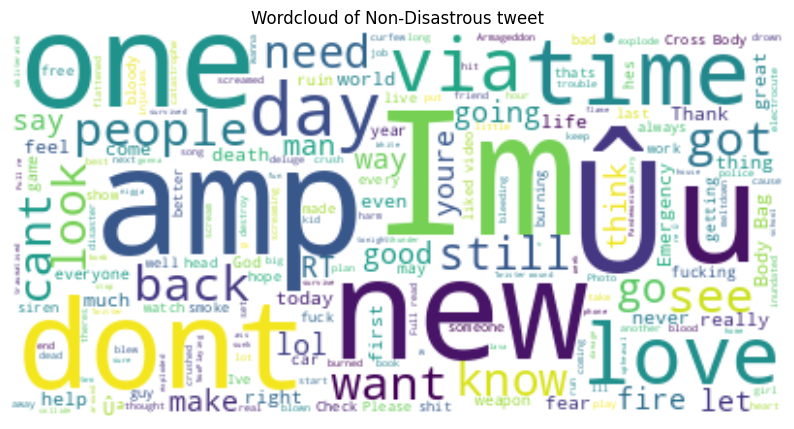

In [ ]:
# Concatenate all preprocessed text in the dataset for target value 0 (non-disastrous) into a single string
k_0 = (' '.join(df_0['preprocess']))

# Generate a word cloud for the non-disastrous tweets using the concatenated string
wordcloud = WordCloud(background_color="white", max_words=1000,
                      max_font_size=90,
                      contour_width=0.01, contour_color='green').generate(k_0)

# Set the figure size for the word cloud plot
plt.figure(figsize=(10, 10))

# Display the generated word cloud
plt.imshow(wordcloud, interpolation='bilinear')

# Remove the axis lines from the plot
plt.axis('off')

# Set the title for the word cloud plot
plt.title('Wordcloud of Non-Disastrous tweet')


In [ ]:
# Define a function to create a corpus (collection of words) from the preprocessed text in the dataframe
def create_corpus(df):
    corpus = []  # Initialize an empty corpus

    # Iterate through each preprocessed tweet in the dataframe
    for tweet in tqdm(df['preprocess']):
        # Tokenize the tweet, convert words to lowercase, and filter out non-alphabetic words and stopwords
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() == 1) & (word not in stop))]
        corpus.append(words)  # Append the filtered words to the corpus

    return corpus  # Return the created corpus

In [ ]:
corpus=create_corpus(df)


100%|██████████| 7613/7613 [00:01<00:00, 4558.40it/s]


In [ ]:
# # Downloading glove folder and unzipping the contents

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip
# !ls
# !pwd

In [ ]:
embedding_dict = {}  # Initialize an empty dictionary to store word embeddings

# Open the GloVe file containing pre-trained word vectors
with open('/content/drive/MyDrive/glove.6B.100d.txt', 'r') as f:
    # Iterate through each line in the GloVe file
    for line in f:
        values = line.split()  # Split the line into word and corresponding vector values
        word = values[0]  # Extract the word
        vectors = np.asarray(values[1:], 'float32')  # Convert the vector values to a NumPy array of float32
        embedding_dict[word] = vectors  # Add the word and its vector to the embedding dictionary

# Close the file after reading
f.close()


In [ ]:
# Set the maximum length for each tweet sequence
MAX_LEN = 50

# Initialize the tokenizer object
tokenizer_obj = Tokenizer()

# Fit the tokenizer on the corpus
tokenizer_obj.fit_on_texts(corpus)

# Convert the corpus text to sequences of integer tokens
sequences = tokenizer_obj.texts_to_sequences(corpus)

# Pad the token sequences to ensure they all have the same length
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 14609


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 14609/14609 [00:00<00:00, 323225.94it/s]


## Model Building

##Navie-Bais Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
target = df['target']

X_train, X_test, y_train, y_test = train_test_split(df['preprocess'],target  , test_size=0.2, random_state=42)

model_one = Pipeline([
                    ("tfidf", TfidfVectorizer()), 
                    ("clf", MultinomialNB()) 
])

# Fit the pipeline to the training data
model_one.fit(X_train, y_train)
preds = model_one.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [ ]:
len(y_train)

6090

In [ ]:
model_one_results = calculate_results(y_true=y_test,
                                     y_pred=preds)
model_one_results

{'accuracy': 80.17071569271175,
 'precision': 0.8057063621995753,
 'recall': 0.8017071569271176,
 'f1': 0.7976251567533502}

##MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()
model_two = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000)
model_two.fit(X_train, y_train)
model_two.fit(X_train, y_train)
preds = model_two.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       874
           1       0.73      0.69      0.71       649

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



In [ ]:
model_two_results = calculate_results(y_true=y_test,
                                     y_pred=preds)
model_two_results

{'accuracy': 75.7715036112935,
 'precision': 0.7566902864446062,
 'recall': 0.757715036112935,
 'f1': 0.7569236122745836}

##LSTM Model


In [ ]:
# Initialize a Sequential model
model = Sequential()

# # Create an embedding layer with the pre-trained embedding_matrix
embedding = Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                       input_length=MAX_LEN, trainable=False)

# # Add the embedding layer to the model
model.add(embedding)

# # Add a SpatialDropout1D layer to the model with dropout rate of 0.2
model.add(SpatialDropout1D(0.2))

# # Add an LSTM layer to the model with 64 hidden units, dropout rate of 0.2, and recurrent dropout rate of 0.2
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# # Add a Dense output layer with a sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# # Initialize an Adam optimizer with a learning rate of 1e-5
optimzer = Adam(learning_rate=1e-5)

# # Compile the model with binary crossentropy loss, the Adam optimizer, and accuracy as the evaluation metric
model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy'])

In [ ]:
train=tweet_pad[:df.shape[0]]
test=tweet_pad[df.shape[0]:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,df['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [ ]:
len(X_train),  len(X_test), len(y_train), len(y_test)




(6471, 1142, 6471, 1142)

In [ ]:
#Fit the model to the training data with specified batch size, epochs, and validation data,
#and display progress after each epoch using verbose=2
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=4, epochs=10,
                    validation_data=(X_test, y_test), verbose=2, callbacks = [early_stop])


Epoch 1/10
1618/1618 - 326s - loss: 0.6878 - accuracy: 0.5710 - val_loss: 0.6376 - val_accuracy: 0.6226 - 326s/epoch - 201ms/step
Epoch 2/10
1618/1618 - 315s - loss: 0.5668 - accuracy: 0.7412 - val_loss: 0.5087 - val_accuracy: 0.7846 - 315s/epoch - 195ms/step
Epoch 3/10
1618/1618 - 313s - loss: 0.5395 - accuracy: 0.7529 - val_loss: 0.4932 - val_accuracy: 0.7907 - 313s/epoch - 193ms/step
Epoch 4/10
1618/1618 - 313s - loss: 0.5253 - accuracy: 0.7614 - val_loss: 0.4828 - val_accuracy: 0.7968 - 313s/epoch - 193ms/step
Epoch 5/10
1618/1618 - 332s - loss: 0.5186 - accuracy: 0.7634 - val_loss: 0.4734 - val_accuracy: 0.8012 - 332s/epoch - 205ms/step
Epoch 6/10
1618/1618 - 314s - loss: 0.5075 - accuracy: 0.7699 - val_loss: 0.4649 - val_accuracy: 0.8074 - 314s/epoch - 194ms/step
Epoch 7/10
1618/1618 - 318s - loss: 0.4975 - accuracy: 0.7759 - val_loss: 0.4597 - val_accuracy: 0.8091 - 318s/epoch - 196ms/step
Epoch 8/10
1618/1618 - 312s - loss: 0.4987 - accuracy: 0.7747 - val_loss: 0.4575 - val_acc

In [ ]:
y_pre=model.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(1142)

36/36 [==============================] - 1s 15ms/step


In [ ]:
 print(classification_report(y_test, y_pre))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       640
           1       0.82      0.73      0.77       502

    accuracy                           0.81      1142
   macro avg       0.81      0.80      0.80      1142
weighted avg       0.81      0.81      0.81      1142



In [ ]:
 print(accuracy_score(y_test, y_pre))

0.8099824868651488


In [ ]:
model_results = calculate_results(y_true=y_test,
                                     y_pred=y_pre)
model_results

{'accuracy': 80.99824868651488,
 'precision': 0.8109690227445432,
 'recall': 0.8099824868651488,
 'f1': 0.8082370687372982}

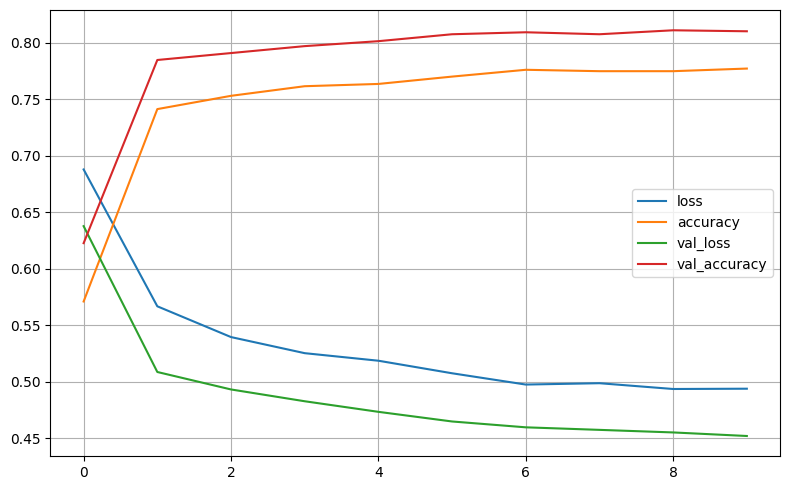

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()

plt.show()

In [ ]:
# Initialize a Sequential model
from tensorflow.keras.layers import Bidirectional
model_four = Sequential()

# Create an embedding layer with the pre-trained embedding_matrix
embedding = Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                      input_length=MAX_LEN, trainable=False)

# Add the embedding layer to the model
model_four.add(embedding)

# Add a SpatialDropout1D layer to the model_four with dropout rate of 0.2
model_four.add(SpatialDropout1D(0.2))

# Add an LSTM layer to the model_four with 64 hidden units, dropout rate of 0.2, and recurrent dropout rate of 0.2
model_four.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))

# Add a Dense output layer with a sigmoid activation function
model_four.add(Dense(1, activation='sigmoid'))

# Initialize an Adam optimizer with a learning rate of 1e-5
optimzer = Adam(learning_rate=1e-5)

# Compile the model_four with binary crossentropy loss, the Adam optimizer, and accuracy as the evaluation metric
model_four.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy'])

In [ ]:

history = model_four.fit(X_train, y_train, batch_size=10, epochs=10,
                    validation_data=(X_test, y_test), verbose=2)


Epoch 1/10
648/648 - 272s - loss: 0.6759 - accuracy: 0.5770 - val_loss: 0.6142 - val_accuracy: 0.6953 - 272s/epoch - 420ms/step
Epoch 2/10
648/648 - 259s - loss: 0.5417 - accuracy: 0.7444 - val_loss: 0.4890 - val_accuracy: 0.7776 - 259s/epoch - 400ms/step
Epoch 3/10
648/648 - 257s - loss: 0.5084 - accuracy: 0.7677 - val_loss: 0.4714 - val_accuracy: 0.7846 - 257s/epoch - 397ms/step
Epoch 4/10
648/648 - 256s - loss: 0.4957 - accuracy: 0.7704 - val_loss: 0.4621 - val_accuracy: 0.7960 - 256s/epoch - 394ms/step
Epoch 5/10
648/648 - 257s - loss: 0.4899 - accuracy: 0.7728 - val_loss: 0.4528 - val_accuracy: 0.7942 - 257s/epoch - 397ms/step
Epoch 6/10
648/648 - 255s - loss: 0.4732 - accuracy: 0.7866 - val_loss: 0.4473 - val_accuracy: 0.7977 - 255s/epoch - 393ms/step
Epoch 7/10
648/648 - 257s - loss: 0.4775 - accuracy: 0.7833 - val_loss: 0.4437 - val_accuracy: 0.7995 - 257s/epoch - 397ms/step
Epoch 8/10
648/648 - 256s - loss: 0.4728 - accuracy: 0.7838 - val_loss: 0.4405 - val_accuracy: 0.8030 - 

In [ ]:
y_pre=model.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(1142)

36/36 [==============================] - 1s 23ms/step


In [ ]:
 print(classification_report(y_test, y_pre))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       640
           1       0.82      0.73      0.77       502

    accuracy                           0.81      1142
   macro avg       0.81      0.80      0.80      1142
weighted avg       0.81      0.81      0.81      1142



In [ ]:
 print(accuracy_score(y_test, y_pre))

0.8099824868651488


In [ ]:
model_four_results = calculate_results(y_true=y_test,
                                     y_pred=y_pre)
model_four_results

{'accuracy': 80.99824868651488,
 'precision': 0.8109690227445432,
 'recall': 0.8099824868651488,
 'f1': 0.8082370687372982}

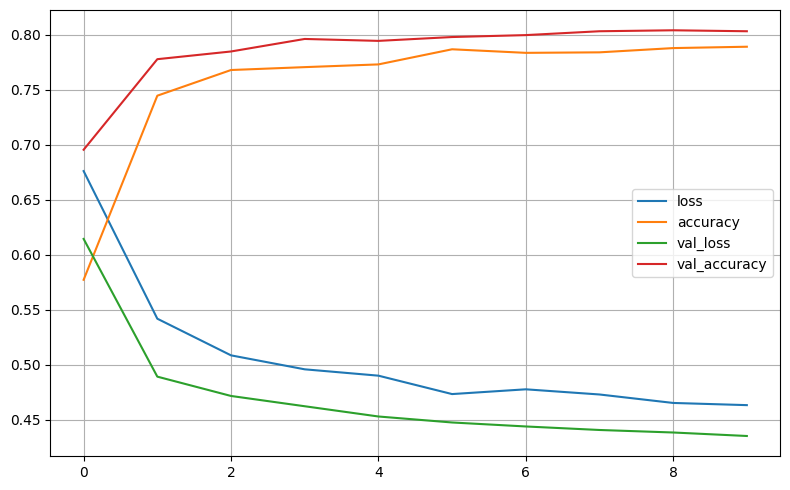

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()

plt.show()

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.2 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
df_for_bert = df[['preprocess', 'target']]
train = df_for_bert[:6090]

test = df_for_bert[6090:]
y_train = train['target']
y_test = test['target']

In [ ]:
x_train = tokenizer(
    text=train.preprocess.tolist(),
    add_special_tokens=True,
    max_length=32,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_test = tokenizer(
    text=test.preprocess.tolist(),
    add_special_tokens=True,
    max_length=32,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import BinaryCrossentropy




input_ids = Input(shape=(32,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(32,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy




optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [ ]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
  epochs=10,
  validation_data= ({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test),
    batch_size=10
)

Epoch 1/10
609/609 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.9061

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


609/609 [==============================] - 208s 341ms/step - loss: 0.2655 - accuracy: 0.9061 - val_loss: 0.4918 - val_accuracy: 0.8135
Epoch 2/10
609/609 [==============================] - 197s 324ms/step - loss: 0.2651 - accuracy: 0.9077 - val_loss: 0.4949 - val_accuracy: 0.8129
Epoch 3/10
609/609 [==============================] - 191s 314ms/step - loss: 0.2616 - accuracy: 0.9066 - val_loss: 0.4983 - val_accuracy: 0.8135
Epoch 4/10
609/609 [==============================] - 197s 323ms/step - loss: 0.2679 - accuracy: 0.9033 - val_loss: 0.4939 - val_accuracy: 0.8175
Epoch 5/10
609/609 [==============================] - 197s 323ms/step - loss: 0.2581 - accuracy: 0.9115 - val_loss: 0.4954 - val_accuracy: 0.8155
Epoch 6/10
609/609 [==============================] - 197s 323ms/step - loss: 0.2555 - accuracy: 0.9089 - val_loss: 0.4990 - val_accuracy: 0.8155
Epoch 7/10
609/609 [==============================] - 197s 323ms/step - loss: 0.2599 - accuracy: 0.9064 - val_loss: 0.5007 - val_accura

In [ ]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})


48/48 [==============================] - 13s 276ms/step


In [ ]:
y_predicted = np.where(predicted>0.5,1,0)

In [ ]:
model_five_results = calculate_results(y_true=y_test,
                                     y_pred=y_predicted)
model_five_results

{'accuracy': 81.28693368351936,
 'precision': 0.812852853020977,
 'recall': 0.8128693368351937,
 'f1': 0.8128607435369011}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"model_one_MNNB": model_one_results,
                                  "model_two_MLP": model_two_results,
                                  "lstm": model_results,
                                  "Bidirectional": model_four_results,
                                  "BERT": model_five_results
                                  })
all_model_results = all_model_results.transpose()
all_model_results


,accuracy,precision,recall,f1
model_one_MNNB,80.170716,0.805706,0.801707,0.797625
model_two_MLP,75.771504,0.756690,0.757715,0.756924
lstm,80.998249,0.810969,0.809982,0.808237
Bidirectional,80.998249,0.810969,0.809982,0.808237
BERT,81.286934,0.812853,0.812869,0.812861


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

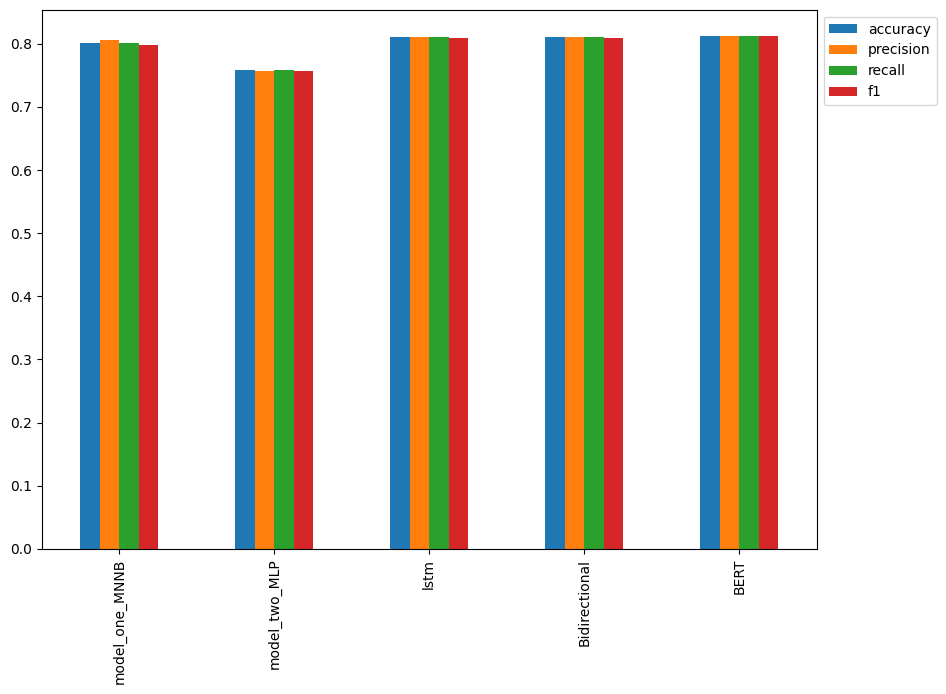

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


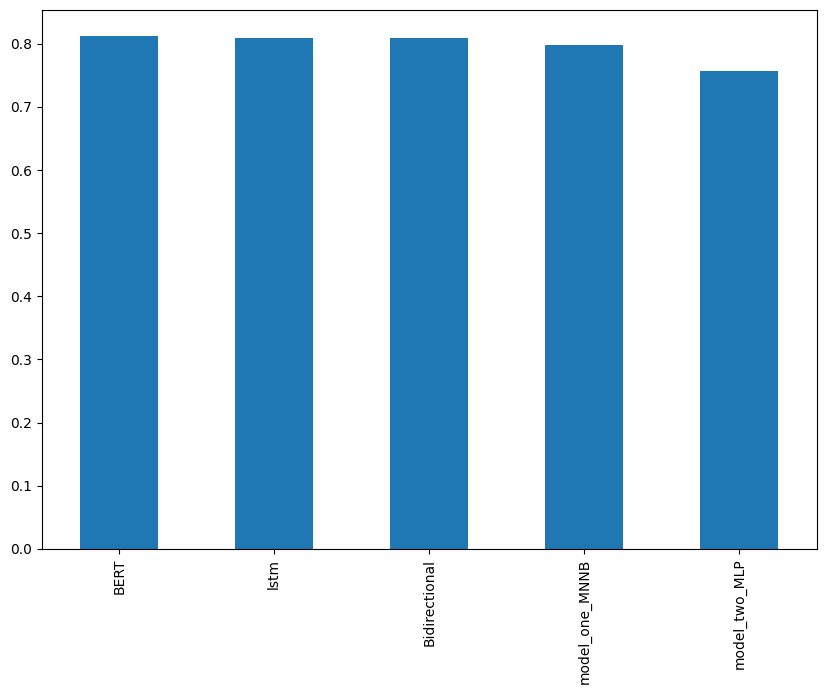

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));
